# Precious Metals Multivariate Forecasting — VAR + LSTM (Hybrid Residual)



- **VAR** (Vector Autoregression) baseline
- **Multivariate LSTM**
- **Hybrid VAR + LSTM (Residual Learning)**

### Files used (your two CSVs)
- `precious_metals_historical_data.csv`
- `precious_metals_forecast_to_march2026.csv`



## 0) Run this first (reproducibility + utilities)

This cell:
- sets random seeds
- imports libraries
- defines robust metric utilities (works across scikit-learn versions)


In [1]:
# --- Reproducibility & Imports ---
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Deep learning
import tensorflow as tf
tf.random.set_seed(SEED)
from tensorflow.keras import layers, models

# Classical TS
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Metrics (avoid version-specific flags like squared=False)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

print("Python:", os.sys.version.split()[0])
print("TensorFlow:", tf.__version__)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), 1e-9)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def eval_forecast(y_true_df, y_pred_df, name="model"):
    """Evaluate forecasts safely (align by index + common columns)."""
    common_cols = [c for c in y_true_df.columns if c in y_pred_df.columns]
    y_true_df = y_true_df[common_cols].dropna()
    y_pred_df = y_pred_df.loc[y_true_df.index, common_cols]

    rows = []
    for c in common_cols:
        yt = y_true_df[c].values
        yp = y_pred_df[c].values
        rmse = float(np.sqrt(mean_squared_error(yt, yp)))
        rows.append({
            "model": name,
            "series": c,
            "MAE": float(mean_absolute_error(yt, yp)),
            "RMSE": rmse,
            "MAPE%": float(mape(yt, yp)),
        })
    return pd.DataFrame(rows)

def adf_pvalue(series):
    series = pd.Series(series).dropna()
    if len(series) < 20:
        return np.nan
    return float(adfuller(series, autolag="AIC")[1])

def make_windows(arr2d, window):
    X, y = [], []
    for i in range(window, len(arr2d)):
        X.append(arr2d[i-window:i, :])
        y.append(arr2d[i, :])  # next step
    return np.array(X), np.array(y)


Python: 3.11.14
TensorFlow: 2.16.2


## 1) Load & merge data (2 CSVs)

I:
- parse dates robustly
- merge on `Date`
- coerce numeric columns safely (handles commas/$/spaces)
- fill remaining gaps (ffill/bfill)


In [2]:
HIST_PATH = "precious_metals_historical_data.csv"
FUT_PATH  = "precious_metals_forecast_to_march2026.csv"

hist = pd.read_csv(HIST_PATH)
fut  = pd.read_csv(FUT_PATH)

def find_date_col(df):
    for c in df.columns:
        if str(c).lower() in ["date", "ds", "time", "datetime"]:
            return c
    return df.columns[0]

DATE_COL_H = find_date_col(hist)
DATE_COL_F = find_date_col(fut)

hist[DATE_COL_H] = pd.to_datetime(hist[DATE_COL_H], errors="coerce")
fut[DATE_COL_F]  = pd.to_datetime(fut[DATE_COL_F], errors="coerce")

hist = hist.dropna(subset=[DATE_COL_H]).sort_values(DATE_COL_H)
fut  = fut.dropna(subset=[DATE_COL_F]).sort_values(DATE_COL_F)

hist = hist.rename(columns={DATE_COL_H: "Date"})
fut  = fut.rename(columns={DATE_COL_F: "Date"})

# Merge & index
df = pd.merge(hist, fut, on="Date", how="outer", suffixes=("", "_fut"))
df = df.sort_values("Date").reset_index(drop=True)
df = df.set_index("Date").sort_index()

# Convert ONLY object columns to numeric safely
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = (
            df[c].astype(str)
                 .str.replace(",", "", regex=False)
                 .str.replace("$", "", regex=False)
                 .str.replace(" ", "", regex=False)
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.ffill().bfill()

print("Merged shape:", df.shape)
df.head()


Merged shape: (2522, 17)


,Silver_Price,Gold_Price,Platinum_Price,Silver_Returns,Gold_Returns,Platinum_Returns,Gold_Silver_Ratio,Silver_Volatility_30d,Gold_Volatility_30d,Platinum_Volatility_30d,Silver_MA50,Silver_MA200,Gold_MA50,Gold_MA200,Silver,Gold,Platinum
Date,,,,,,,,,,,,,,,,,
2016-02-03,13.95,109.250000,84.940002,0.015771,0.012082,0.027313,7.831541,0.2354,0.230137,0.241552,14.623,16.69475,117.5962,122.09305,90.920017,469.126537,208.800413
2016-02-04,14.17,110.570000,87.260002,0.015771,0.012082,0.027313,7.803105,0.2354,0.230137,0.241552,14.623,16.69475,117.5962,122.09305,90.920017,469.126537,208.800413
2016-02-05,14.34,112.320000,87.919998,0.011997,0.015827,0.007564,7.832636,0.2354,0.230137,0.241552,14.623,16.69475,117.5962,122.09305,90.920017,469.126537,208.800413
2016-02-08,14.59,113.830002,89.199997,0.017434,0.013444,0.014559,7.801919,0.2354,0.230137,0.241552,14.623,16.69475,117.5962,122.09305,90.920017,469.126537,208.800413
2016-02-09,14.51,113.580002,89.849998,-0.005483,-0.002196,0.007287,7.827705,0.2354,0.230137,0.241552,14.623,16.69475,117.5962,122.09305,90.920017,469.126537,208.800413


## 2) Choose target columns

For my dataset, the main target price columns are:

- `Silver_Price`
- `Gold_Price`
- `Platinum_Price`



In [3]:
TARGET_COLS = ["Silver_Price", "Gold_Price", "Platinum_Price"]

# Keep only rows where targets exist (prevents leakage from future-only feature rows)
data = df[TARGET_COLS].copy().dropna()

print("Target data shape:", data.shape)
data.head()


Target data shape: (2522, 3)


,Silver_Price,Gold_Price,Platinum_Price
Date,,,
2016-02-03,13.95,109.250000,84.940002
2016-02-04,14.17,110.570000,87.260002
2016-02-05,14.34,112.320000,87.919998
2016-02-08,14.59,113.830002,89.199997
2016-02-09,14.51,113.580002,89.849998


## 3) EDA 

- Plot target series
- Correlation matrix


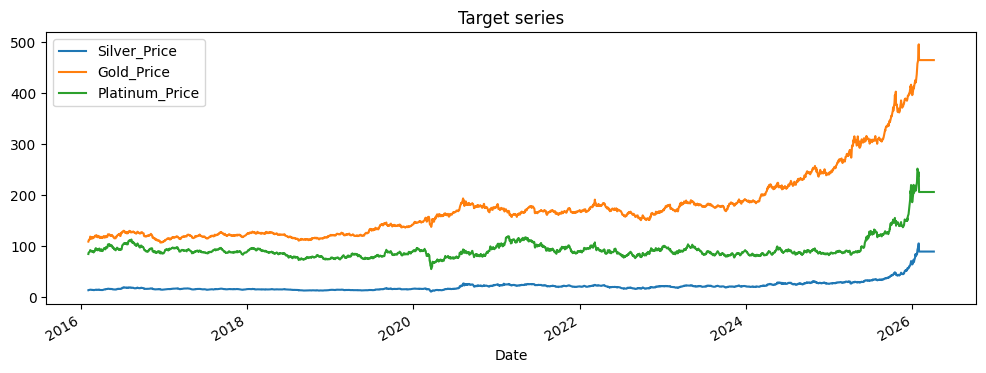

Correlation:
                Silver_Price  Gold_Price  Platinum_Price
Silver_Price        1.000000    0.912654        0.881488
Gold_Price          0.912654    1.000000        0.705425
Platinum_Price      0.881488    0.705425        1.000000


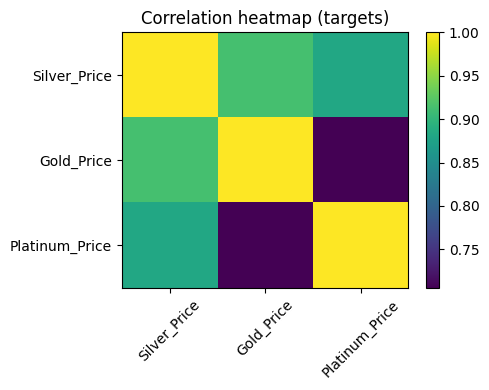

In [4]:
data.plot(figsize=(12,4))
plt.title("Target series")
plt.show()

corr = data.corr()
print("Correlation:")
print(corr)

plt.figure(figsize=(5,4))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(TARGET_COLS)), TARGET_COLS, rotation=45)
plt.yticks(range(len(TARGET_COLS)), TARGET_COLS)
plt.title("Correlation heatmap (targets)")
plt.colorbar()
plt.tight_layout()
plt.show()


## 4) Stationarity & transformations (for VAR)

I use:
- optional log transform (only if all prices > 0)
- first differencing

VAR generally works best on stationary series.


In [5]:
adf_before = {c: adf_pvalue(data[c]) for c in TARGET_COLS}
print("ADF p-values (before):")
for k, v in adf_before.items():
    print(f"  {k}: {v:.4f}")

use_log = bool((data.min() > 0).all())
print("\nuse_log =", use_log)

tdata = np.log(data) if use_log else data.copy()
ddata = tdata.diff().dropna()

adf_after = {c: adf_pvalue(ddata[c]) for c in TARGET_COLS}
print("\nADF p-values (after diff):")
for k, v in adf_after.items():
    print(f"  {k}: {v:.4f}")

ddata.head()


ADF p-values (before):
  Silver_Price: 1.0000
  Gold_Price: 1.0000
  Platinum_Price: 0.9809

use_log = True

ADF p-values (after diff):
  Silver_Price: 0.0000
  Gold_Price: 0.0000
  Platinum_Price: 0.0000


,Silver_Price,Gold_Price,Platinum_Price
Date,,,
2016-02-04,0.015648,0.012010,0.026947
2016-02-05,0.011926,0.015703,0.007535
2016-02-08,0.017284,0.013354,0.014454
2016-02-09,-0.005498,-0.002199,0.007261
2016-02-10,0.002753,0.007718,0.003777


## 5) Train/test split (time-based)

I  use the last 20% as test.


In [6]:
TEST_FRAC = 0.2
n = len(ddata)
split = int(n * (1 - TEST_FRAC))

train = ddata.iloc[:split].copy()
test  = ddata.iloc[split:].copy()

print("Train:", train.shape, "Test:", test.shape)
train.tail()


Train: (2016, 3) Test: (505, 3)


,Silver_Price,Gold_Price,Platinum_Price
Date,,,
2024-02-01,0.014245,0.010347,-0.001304
2024-02-02,-0.021926,-0.009498,-0.024624
2024-02-05,-0.013586,-0.005529,0.009079
2024-02-06,0.001952,0.005211,0.003849
2024-02-07,-0.008815,-0.000265,-0.025287


## Helper: invert differencing 

I forecast in differenced space, then reconstruct level series.


In [7]:
last_train_t = tdata.loc[train.index[-1]]

def invert_diff(forecast_diff: pd.DataFrame, last_value_transformed: pd.Series):
    levels = forecast_diff.cumsum()
    levels = levels.add(last_value_transformed, axis=1)
    return levels

def to_original_scale(levels_t: pd.DataFrame):
    return np.exp(levels_t) if use_log else levels_t.copy()

actual_level = to_original_scale(tdata.loc[test.index])


## 6) VAR baseline

- select lag via AIC (bounded)
- forecast horizon = test length
- evaluate on original scale


In [8]:
model = VAR(train)

maxlags = min(30, max(2, len(train)//10))
order = model.select_order(maxlags=maxlags)
best_lag = int(order.aic)
best_lag = max(1, best_lag)

print("Selected lag (AIC):", best_lag)

var_res = model.fit(best_lag)

h = len(test)
var_forecast_diff = var_res.forecast(y=train.values[-best_lag:], steps=h)
var_forecast_diff = pd.DataFrame(var_forecast_diff, index=test.index, columns=TARGET_COLS)

var_level_t = invert_diff(var_forecast_diff, last_train_t)
var_level = to_original_scale(var_level_t)

var_metrics = eval_forecast(actual_level, var_level, name="VAR")
var_metrics


Selected lag (AIC): 7


/opt/miniconda3/envs/tf-metal/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,model,series,MAE,RMSE,MAPE%
0,VAR,Silver_Price,13.643475,20.212099,32.444298
1,VAR,Gold_Price,82.953015,103.918331,25.930368
2,VAR,Platinum_Price,29.707247,47.241170,21.159659


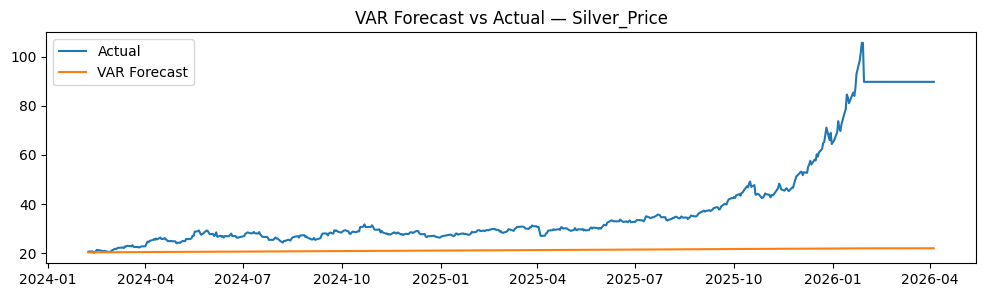

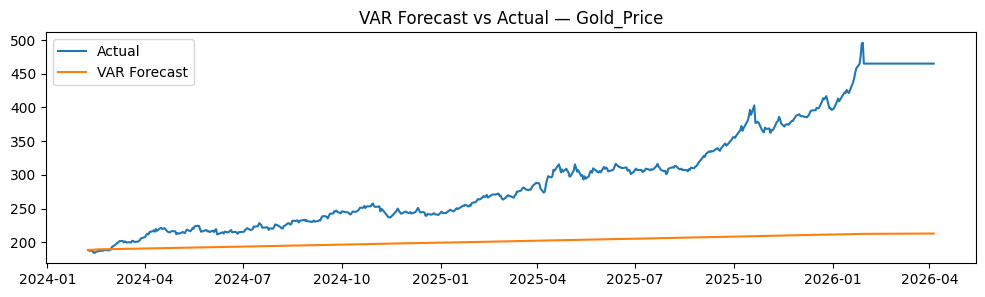

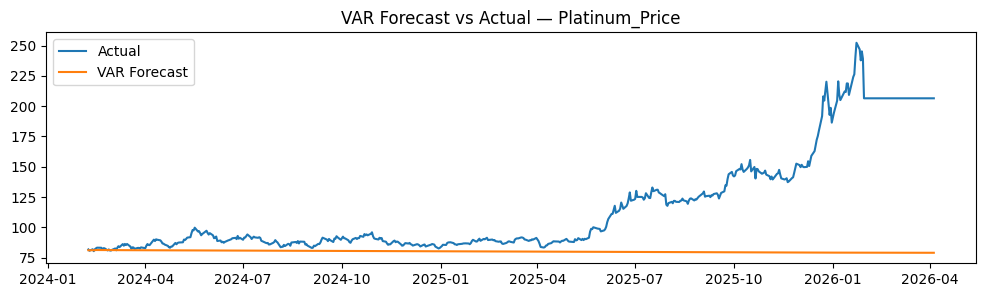

In [9]:
for c in TARGET_COLS:
    plt.figure(figsize=(12,3))
    plt.plot(actual_level.index, actual_level[c], label="Actual")
    plt.plot(var_level.index, var_level[c], label="VAR Forecast")
    plt.title(f"VAR Forecast vs Actual — {c}")
    plt.legend()
    plt.show()


## 7) Multivariate LSTM  

I standardize the differenced series and train an LSTM to predict the next step.


X_train: (1986, 30, 3) y_train: (1986, 3)
X_test: (505, 30, 3) y_test: (505, 3)


2026-02-02 17:59:05.812543: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-02-02 17:59:05.812567: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-02 17:59:05.812573: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-02 17:59:05.812588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-02 17:59:05.812598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


2026-02-02 17:59:06.297395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.9871 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9829 - val_loss: 1.0233 - learning_rate: 0.0010
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9787 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9750 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9682 - val_loss: 1.0236 - learning_rate: 0.0010
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9601 - val_loss: 1.0300 - learning_rate: 0.0010
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9465 - val_loss: 1.0379 - learning_rate: 0.0010
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9479 - val_loss: 1.0366 - learning_rate: 0.0010
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9362 - val_loss: 1.0308 - learning_rate: 5.0000e-04
Epoch 10/80
50/50 ━━━━━━━━

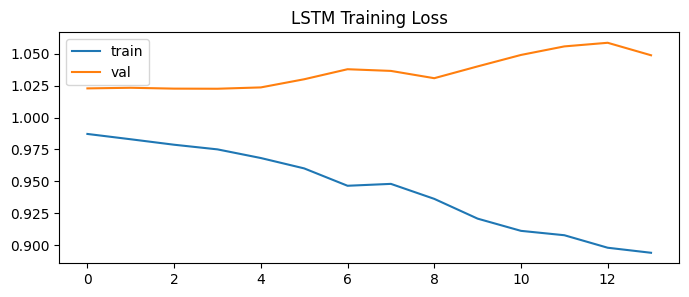

In [10]:
WINDOW = 30

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values)
test_scaled  = scaler.transform(test.values)

X_train, y_train = make_windows(train_scaled, WINDOW)

combined = np.vstack([train_scaled[-WINDOW:], test_scaled])
X_test, y_test = make_windows(combined, WINDOW)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

tf.keras.backend.clear_session()
lstm = models.Sequential([
    layers.Input(shape=(WINDOW, len(TARGET_COLS))),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(len(TARGET_COLS))
])
lstm.compile(optimizer="adam", loss="mse")
lstm.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
]

history = lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,3))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()


In [11]:
yhat_scaled = lstm.predict(X_test, verbose=0)
yhat_diff = scaler.inverse_transform(yhat_scaled)

lstm_forecast_diff = pd.DataFrame(yhat_diff, index=test.index, columns=TARGET_COLS)
lstm_level_t = invert_diff(lstm_forecast_diff, last_train_t)
lstm_level = to_original_scale(lstm_level_t)

lstm_metrics = eval_forecast(actual_level, lstm_level, name="LSTM")
lstm_metrics


,model,series,MAE,RMSE,MAPE%
0,LSTM,Silver_Price,15.098506,21.459378,36.652396
1,LSTM,Gold_Price,89.134514,112.417861,27.783040
2,LSTM,Platinum_Price,41.751719,60.023031,31.450240


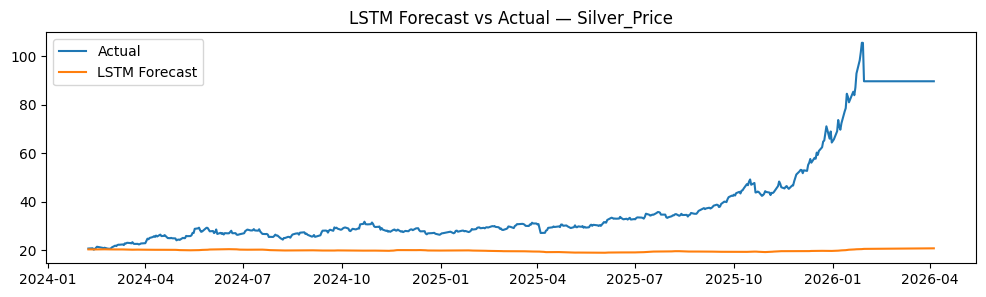

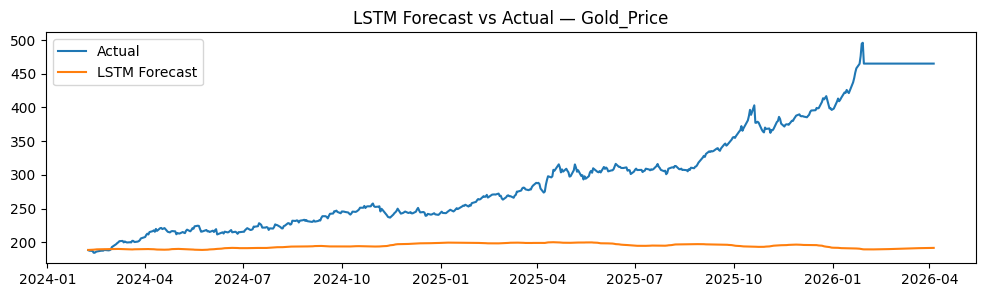

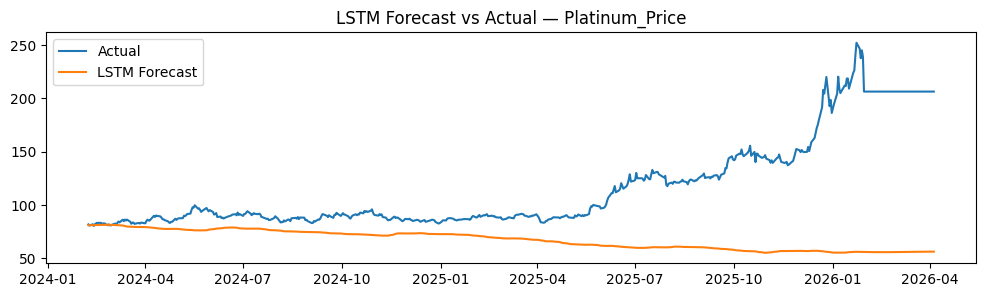

In [12]:
for c in TARGET_COLS:
    plt.figure(figsize=(12,3))
    plt.plot(actual_level.index, actual_level[c], label="Actual")
    plt.plot(lstm_level.index, lstm_level[c], label="LSTM Forecast")
    plt.title(f"LSTM Forecast vs Actual — {c}")
    plt.legend()
    plt.show()


## 8) Hybrid VAR + LSTM (Residual Learning)

**Idea:** VAR captures linear cross-series structure; LSTM learns the residual non-linear patterns.

Process:
1. Fit VAR on train (done)
2. Residuals (train): `residual = actual_diff - var_fitted_diff`
3. Train residual-LSTM on residuals
4. Forecast residuals on test and add to VAR forecast


Residual windows: (1979, 30, 3) (1979, 3)
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.9901 - val_loss: 1.0409 - learning_rate: 0.0010
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9845 - val_loss: 1.0398 - learning_rate: 0.0010
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9817 - val_loss: 1.0389 - learning_rate: 0.0010
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9788 - val_loss: 1.0394 - learning_rate: 0.0010
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9747 - val_loss: 1.0402 - learning_rate: 0.0010
Epoch 6/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9649 - val_loss: 1.0388 - learning_rate: 5.0000e-04
Epoch 7/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9606 - val_loss: 1.0399 - learning_rate: 5.0000e-04
Epoch 8/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9553 - val_loss: 1.0413 - learning_rate: 5.0000e-04
Epoch 9/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9507 - val_lo

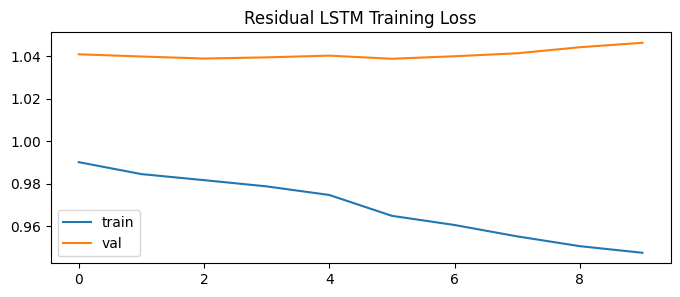

,model,series,MAE,RMSE,MAPE%
0,VAR+LSTM(Hybrid),Silver_Price,13.228874,19.476879,31.581090
1,VAR+LSTM(Hybrid),Gold_Price,94.223482,117.140514,29.542503
2,VAR+LSTM(Hybrid),Platinum_Price,34.701526,52.572919,25.407713


In [13]:
# VAR fitted values on training window (aligned from best_lag onward)
var_fitted_train = var_res.fittedvalues
train_aligned = train.loc[var_fitted_train.index]
residual_train = train_aligned - var_fitted_train

# Scale residuals
res_scaler = StandardScaler()
res_train_scaled = res_scaler.fit_transform(residual_train.values)

Xr, yr = make_windows(res_train_scaled, WINDOW)
print("Residual windows:", Xr.shape, yr.shape)

tf.keras.backend.clear_session()
res_lstm = models.Sequential([
    layers.Input(shape=(WINDOW, len(TARGET_COLS))),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(len(TARGET_COLS))
])
res_lstm.compile(optimizer="adam", loss="mse")

res_hist = res_lstm.fit(
    Xr, yr,
    validation_split=0.2,
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(8,3))
plt.plot(res_hist.history["loss"], label="train")
plt.plot(res_hist.history["val_loss"], label="val")
plt.title("Residual LSTM Training Loss")
plt.legend()
plt.show()

# Predict residuals for test using teacher-forced windows (evaluation mode)
# Build "true" residuals for test: actual_diff - VAR_diff_forecast
residual_test_true = test - var_forecast_diff
residual_full = pd.concat([residual_train, residual_test_true], axis=0)

res_full_scaled = res_scaler.transform(residual_full.values)
X_res_all, _ = make_windows(res_full_scaled, WINDOW)
y_index_all = residual_full.index[WINDOW:]

mask = y_index_all.isin(test.index)
X_res_test = X_res_all[mask]

res_hat_scaled = res_lstm.predict(X_res_test, verbose=0)
res_hat = res_scaler.inverse_transform(res_hat_scaled)
residual_hat = pd.DataFrame(res_hat, index=test.index, columns=TARGET_COLS)

# Hybrid diff forecast
hybrid_forecast_diff = var_forecast_diff + residual_hat

# Convert to original scale
hybrid_level_t = invert_diff(hybrid_forecast_diff, last_train_t)
hybrid_level = to_original_scale(hybrid_level_t)

hybrid_metrics = eval_forecast(actual_level, hybrid_level, name="VAR+LSTM(Hybrid)")
hybrid_metrics


## 9) Compare models

We combine metrics across VAR, LSTM, and Hybrid.


In [14]:
all_metrics = pd.concat([var_metrics, lstm_metrics, hybrid_metrics], axis=0).reset_index(drop=True)
all_metrics


,model,series,MAE,RMSE,MAPE%
0,VAR,Silver_Price,13.643475,20.212099,32.444298
1,VAR,Gold_Price,82.953015,103.918331,25.930368
2,VAR,Platinum_Price,29.707247,47.241170,21.159659
3,LSTM,Silver_Price,15.098506,21.459378,36.652396
4,LSTM,Gold_Price,89.134514,112.417861,27.783040
5,LSTM,Platinum_Price,41.751719,60.023031,31.450240
6,VAR+LSTM(Hybrid),Silver_Price,13.228874,19.476879,31.581090
7,VAR+LSTM(Hybrid),Gold_Price,94.223482,117.140514,29.542503
8,VAR+LSTM(Hybrid),Platinum_Price,34.701526,52.572919,25.407713


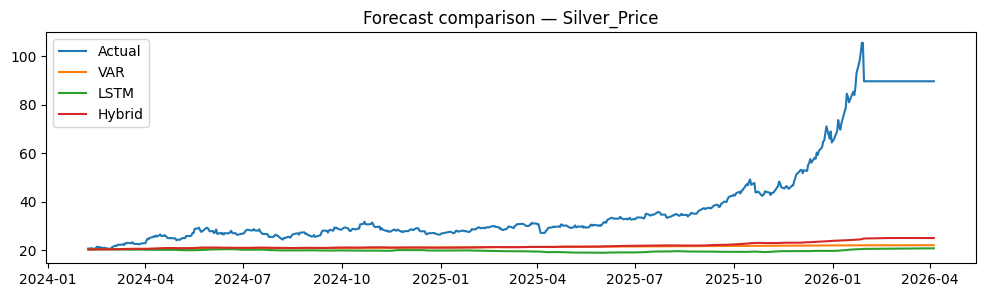

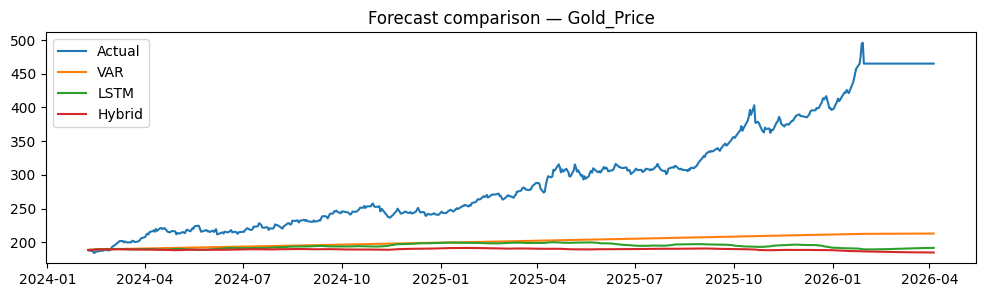

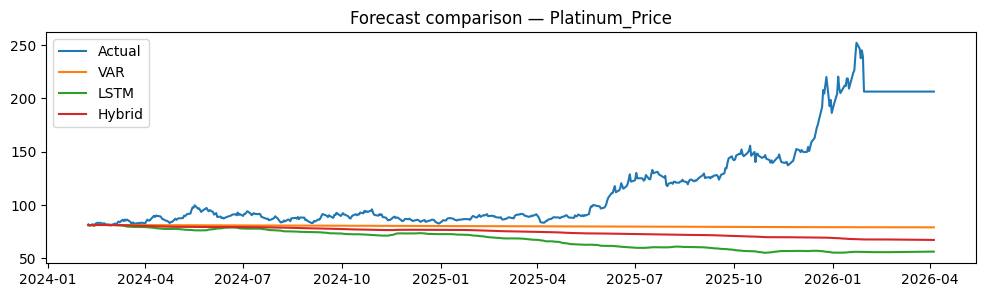

In [15]:
for c in TARGET_COLS:
    plt.figure(figsize=(12,3))
    plt.plot(actual_level.index, actual_level[c], label="Actual")
    plt.plot(var_level.index, var_level[c], label="VAR")
    plt.plot(lstm_level.index, lstm_level[c], label="LSTM")
    plt.plot(hybrid_level.index, hybrid_level[c], label="Hybrid")
    plt.title(f"Forecast comparison — {c}")
    plt.legend()
    plt.show()
